# VAE model with a separate neural network classifier

The code defines and trains a Variational Autoencoder (VAE) model to encode and decode image data, extracts latent features from the encoded images, and then uses a separate neural network classifier to predict glaucoma from these features, evaluating the model's performance using various metrics and visualizations.

VAE Training: We train the VAE to reconstruct images, which learns a latent space representation of the input images. This helps in capturing the underlying patterns and features of the images.

Feature Extraction: After training, we use the encoder part of the VAE to extract latent features from the images.

Classification: You then use these latent features as inputs to a separate neural network classifier. This classifier is trained to distinguish between healthy and glaucoma images based on the latent features provided by the VAE.

Here’s a step-by-step outline of what the code does:

Define and Train VAE:
Create and train the VAE on image data to learn latent representations through reconstruction.

Extract Latent Features:
Use the encoder part of the trained VAE to get the latent representations of test images.

Train Classifier:
Train a classifier using the latent features extracted from the VAE to classify the images into healthy or glaucoma.

Evaluate Performance:
Evaluate the classifier’s performance using various metrics like accuracy, precision, recall, F1 score, etc.

**This approach leverages the VAE for feature extraction and a separate classifier for distinguishing between the classes.**

## 70-15-15

In [45]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# VAE Model Components
latent_dim = 5
input_shape = (64, 64, 3)

# Encoder
def encoder_model(input_shape):
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # Increased capacity
    
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    
    return tf.keras.Model(encoder_input, [z_mean, z_log_var], name='encoder')

# Decoder
def decoder_model(latent_dim):
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 128, activation='relu')(decoder_input)  # Increased capacity
    x = layers.Reshape((16, 16, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    decoder_output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return tf.keras.Model(decoder_input, decoder_output, name='decoder')

# Reparameterization Trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            reconstructed = self(data)
            
            if len(data.shape) > len(reconstructed.shape):
                data = tf.squeeze(data, axis=0)
            
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, reconstructed))
            reconstruction_loss *= np.prod(input_shape)
            
            z_mean, z_log_var = self.encoder(data)
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"loss": total_loss}

# Prepare Data Generators
datagen = ImageDataGenerator(rescale=1./255)

merged_generator = datagen.flow_from_directory(
    'dataset/vae/70_15_15/train_70_15_15',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

# Compile and Train the VAE
encoder = encoder_model(input_shape)
decoder = decoder_model(latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))  # Adjusted learning rate

# Train VAE
vae.fit(merged_generator, epochs=100)  # Increased epochs

# Extract Latent Vectors for Visualization
latent_features = encoder.predict(train_generator)
z_mean = latent_features[0]
labels = train_generator.classes



Found 1388 images belonging to 2 classes.
Epoch 1/100


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 5345.9668
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 4464.5342
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 4244.7646
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 989ms/step - loss: 4163.6035
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 4133.3657
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 4101.7310
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - loss: 4109.8647
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 4099.8359
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 4092.5908
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - loss: 4080.0325
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 4084.1216
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 4063.9026
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 4064.8828
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 4048.3870
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━

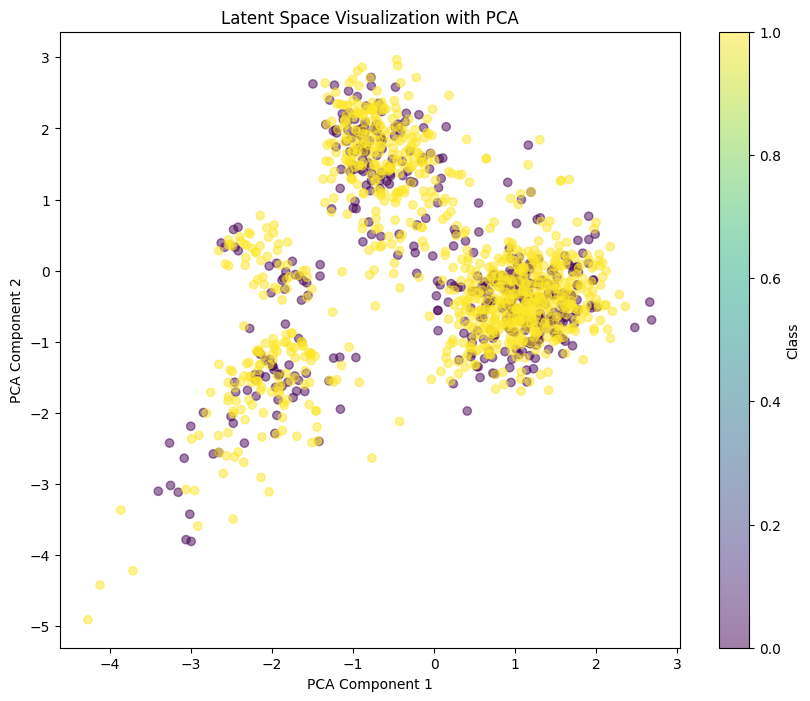

In [46]:
from sklearn.decomposition import PCA
# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
z_mean_pca = pca.fit_transform(z_mean)

# Visualize the Latent Space
plt.figure(figsize=(10, 8))
plt.scatter(z_mean_pca[:, 0], z_mean_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Latent Space Visualization with PCA')
plt.show()

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Extract latent features and labels
def extract_latent_features(generator, encoder):
    latent_features = []
    labels = []
    
    for data_batch, label_batch in generator:
        z_mean, _ = encoder.predict(data_batch)
        latent_features.append(z_mean)
        labels.append(label_batch)
        
        if len(latent_features) * generator.batch_size >= generator.samples:
            break

    latent_features = np.vstack(latent_features)
    labels = np.hstack(labels)
    
    return latent_features, labels

# Prepare training and validation data
train_latent_features, train_labels = extract_latent_features(merged_generator, encoder)

# Apply SMOTE to handle class imbalance
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(train_latent_features, train_labels)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_resampled, 
    y_train_resampled, 
    test_size=0.2, 
    random_state=42
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_classifier(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train classifier
classifier = build_classifier(latent_dim)

history = classifier.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, y_val)
)


Epoch 1/100


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4987 - loss: 0.6992 - val_accuracy: 0.6979 - val_loss: 0.5447
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6971 - loss: 0.5491 - val_accuracy: 0.7406 - val_loss: 0.4866
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7208 - loss: 0.5197 - val_accuracy: 0.7888 - val_loss: 0.4695
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7181 - loss: 0.5236 - val_accuracy: 0.7888 - val_loss: 0.4639
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7682 - loss: 0.4618 - val_accuracy: 0.7941 - val_loss: 0.4524
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7589 - loss: 0.4828 - val_accuracy: 0.7941 - val_loss: 0.4514
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7457 - loss: 0.4873 - val_accuracy: 0.8048 - val_loss: 0.4451
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7712 - loss: 0.4835 - val_accuracy: 0.8021 - val_loss: 0.4

In [49]:
# Evaluate on validation set
val_loss, val_accuracy = classifier.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8316 - loss: 0.3600 
Validation Loss: 0.3774, Validation Accuracy: 0.8209


In [50]:
# Assuming you have a test generator
test_generator = datagen.flow_from_directory(
    'dataset/vae/70_15_15/test_70_15_15',  # Adjust path as needed
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

# Extract test latent features and labels
test_latent_features, test_labels = extract_latent_features(test_generator, encoder)


Found 246 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [51]:
# Evaluate on test set
test_loss, test_accuracy = classifier.evaluate(test_latent_features, test_labels)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Predict on test set
y_test_pred = (classifier.predict(test_latent_features) > 0.5).astype(int)
y_test_prob = classifier.predict(test_latent_features)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8703 - loss: 0.3978 
Test Loss: 0.3815, Test Accuracy: 0.8699
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Test Precision: 0.8935
Test Recall: 0.9152
Test F1 Score: 0.9042
Test Accuracy: 0.8699
Test Average Precision (AP): 0.8882
Test AUC-ROC: 0.8784
Test Confusion Matrix:
[[ 63  18]
 [ 14 151]]


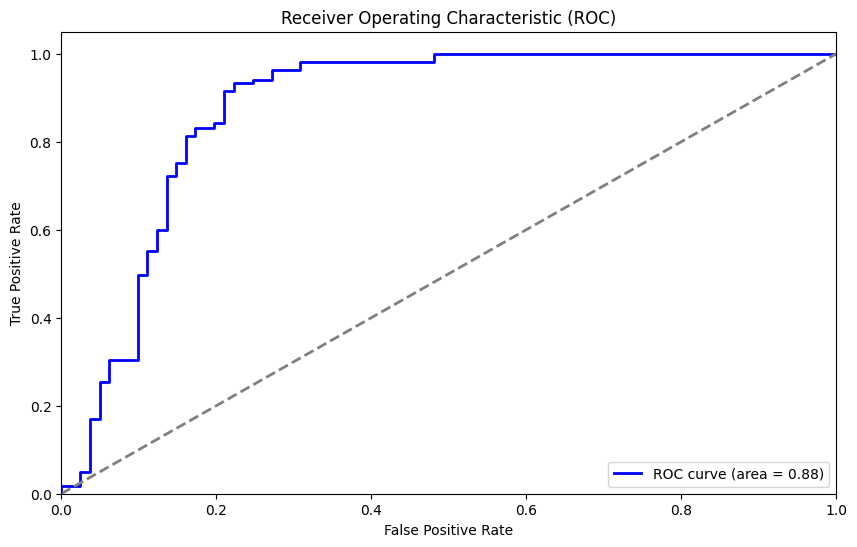

Test Recall (Sensitivity): 0.9152
Test Cohen's Kappa: 0.7018
Test Diagnostic Odds Ratio: 37.7500
Test F2 Score: 0.9107


In [52]:
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, 
                             average_precision_score, roc_auc_score, confusion_matrix, 
                             roc_curve, auc, cohen_kappa_score, fbeta_score)

# Precision, Recall, F1 Score, Accuracy
precision = precision_score(test_labels, y_test_pred)
recall = recall_score(test_labels, y_test_pred)
f1 = f1_score(test_labels, y_test_pred)
accuracy = accuracy_score(test_labels, y_test_pred)

print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Average Precision (AP)
average_precision = average_precision_score(test_labels, y_test_prob)
print(f'Test Average Precision (AP): {average_precision:.4f}')

# AUC-ROC
roc_auc = roc_auc_score(test_labels, y_test_prob)
print(f'Test AUC-ROC: {roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_test_pred)
print(f'Test Confusion Matrix:\n{conf_matrix}')

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Test Recall (Sensitivity)
sensitivity = recall
print(f'Test Recall (Sensitivity): {sensitivity:.4f}')

# Cohen's Kappa
kappa = cohen_kappa_score(test_labels, y_test_pred)
print(f'Test Cohen\'s Kappa: {kappa:.4f}')

# Diagnostic Odds Ratio (DOR)
def diagnostic_odds_ratio(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    dor = (tp * tn) / (fp * fn) if fp * fn != 0 else np.nan
    return dor

dor = diagnostic_odds_ratio(conf_matrix)
print(f'Test Diagnostic Odds Ratio: {dor:.4f}')

# F2 Score
f2 = fbeta_score(test_labels, y_test_pred, beta=2)
print(f'Test F2 Score: {f2:.4f}')


## 80-10-10

In [53]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# VAE Model Components
latent_dim = 5
input_shape = (64, 64, 3)

# Encoder
def encoder_model(input_shape):
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # Increased capacity
    
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    
    return tf.keras.Model(encoder_input, [z_mean, z_log_var], name='encoder')

# Decoder
def decoder_model(latent_dim):
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 128, activation='relu')(decoder_input)  # Increased capacity
    x = layers.Reshape((16, 16, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    decoder_output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return tf.keras.Model(decoder_input, decoder_output, name='decoder')

# Reparameterization Trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            reconstructed = self(data)
            
            if len(data.shape) > len(reconstructed.shape):
                data = tf.squeeze(data, axis=0)
            
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, reconstructed))
            reconstruction_loss *= np.prod(input_shape)
            
            z_mean, z_log_var = self.encoder(data)
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"loss": total_loss}

# Prepare Data Generators
datagen = ImageDataGenerator(rescale=1./255)

merged_generator = datagen.flow_from_directory(
    'dataset/vae/80_10_10/train_80_10_10',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

# Compile and Train the VAE
encoder = encoder_model(input_shape)
decoder = decoder_model(latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))  # Adjusted learning rate

# Train VAE
vae.fit(merged_generator, epochs=100)  # Increased epochs

# Extract Latent Vectors for Visualization
latent_features = encoder.predict(train_generator)
z_mean = latent_features[0]
labels = train_generator.classes


Found 1470 images belonging to 2 classes.
Epoch 1/100


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 7525.9312
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 4600.7246
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - loss: 4395.6445
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 4237.6060
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 4164.9829
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 4125.7300
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 4102.1934
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 4097.4077
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 4079.7502
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 4068.3313
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 4063.5732
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - loss: 4062.0908
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 4051.7266
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - loss: 4047.5212
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5

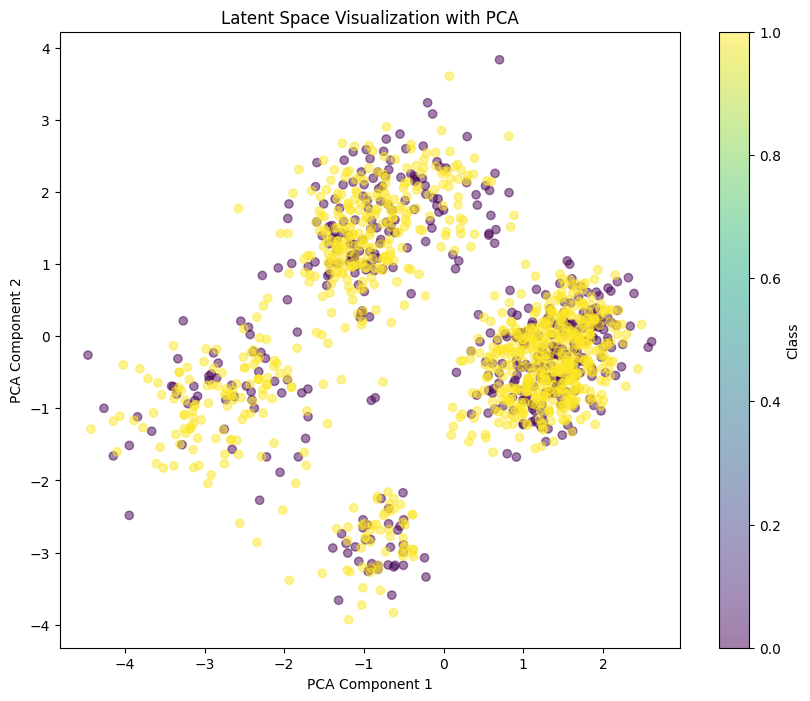

In [54]:
from sklearn.decomposition import PCA
# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
z_mean_pca = pca.fit_transform(z_mean)

# Visualize the Latent Space
plt.figure(figsize=(10, 8))
plt.scatter(z_mean_pca[:, 0], z_mean_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Latent Space Visualization with PCA')
plt.show()

In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Extract latent features and labels
def extract_latent_features(generator, encoder):
    latent_features = []
    labels = []
    
    for data_batch, label_batch in generator:
        z_mean, _ = encoder.predict(data_batch)
        latent_features.append(z_mean)
        labels.append(label_batch)
        
        if len(latent_features) * generator.batch_size >= generator.samples:
            break

    latent_features = np.vstack(latent_features)
    labels = np.hstack(labels)
    
    return latent_features, labels

# Prepare training and validation data
train_latent_features, train_labels = extract_latent_features(merged_generator, encoder)

# Apply SMOTE to handle class imbalance
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(train_latent_features, train_labels)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_resampled, 
    y_train_resampled, 
    test_size=0.2, 
    random_state=42
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_classifier(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train classifier
classifier = build_classifier(latent_dim)

history = classifier.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, y_val)
)


Epoch 1/100


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5751 - loss: 0.6676 - val_accuracy: 0.7323 - val_loss: 0.5071
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6945 - loss: 0.5640 - val_accuracy: 0.7525 - val_loss: 0.4662
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7240 - loss: 0.5325 - val_accuracy: 0.7677 - val_loss: 0.4538
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7494 - loss: 0.4966 - val_accuracy: 0.7828 - val_loss: 0.4435
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7498 - loss: 0.5291 - val_accuracy: 0.7980 - val_loss: 0.4437
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7465 - loss: 0.5039 - val_accuracy: 0.7955 - val_loss: 0.4365
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7708 - loss: 0.4819 - val_accuracy: 0.7904 - val_loss: 0.4421
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7281 - loss: 0.4992 - val_accuracy: 0.8081 - val_loss: 0.4

In [57]:
# Evaluate on validation set
val_loss, val_accuracy = classifier.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.8682 - loss: 0.3746
Validation Loss: 0.3844, Validation Accuracy: 0.8485


In [58]:
# Assuming you have a test generator
test_generator = datagen.flow_from_directory(
    'dataset/vae/80_10_10/test_80_10_10',  # Adjust path as needed
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

# Extract test latent features and labels
test_latent_features, test_labels = extract_latent_features(test_generator, encoder)


Found 164 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [59]:
# Evaluate on test set
test_loss, test_accuracy = classifier.evaluate(test_latent_features, test_labels)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Predict on test set
y_test_pred = (classifier.predict(test_latent_features) > 0.5).astype(int)
y_test_prob = classifier.predict(test_latent_features)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8692 - loss: 0.4594 
Test Loss: 0.4206, Test Accuracy: 0.8841
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


Test Precision: 0.9027
Test Recall: 0.9273
Test F1 Score: 0.9148
Test Accuracy: 0.8841
Test Average Precision (AP): 0.8753
Test AUC-ROC: 0.8537
Test Confusion Matrix:
[[ 43  11]
 [  8 102]]


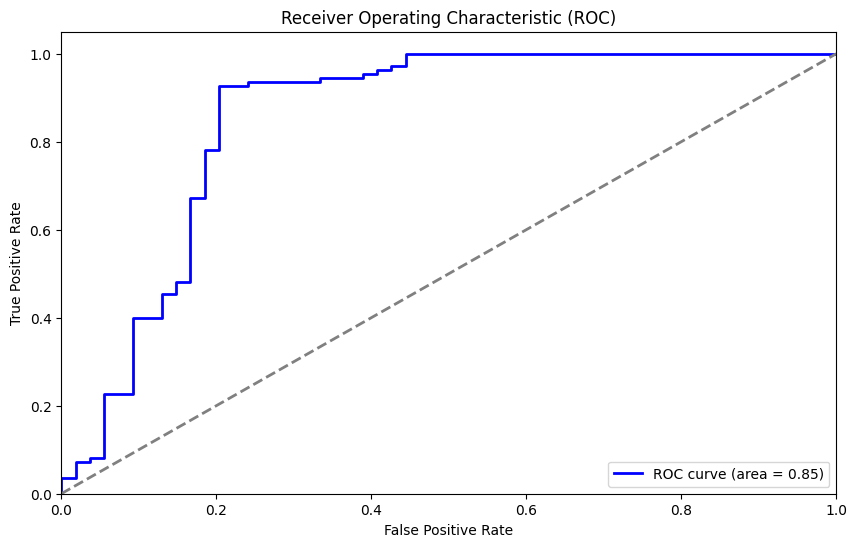

Test Recall (Sensitivity): 0.9273
Test Cohen's Kappa: 0.7339
Test Diagnostic Odds Ratio: 49.8409
Test F2 Score: 0.9222


In [60]:
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, 
                             average_precision_score, roc_auc_score, confusion_matrix, 
                             roc_curve, auc, cohen_kappa_score, fbeta_score)

# Precision, Recall, F1 Score, Accuracy
precision = precision_score(test_labels, y_test_pred)
recall = recall_score(test_labels, y_test_pred)
f1 = f1_score(test_labels, y_test_pred)
accuracy = accuracy_score(test_labels, y_test_pred)

print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Average Precision (AP)
average_precision = average_precision_score(test_labels, y_test_prob)
print(f'Test Average Precision (AP): {average_precision:.4f}')

# AUC-ROC
roc_auc = roc_auc_score(test_labels, y_test_prob)
print(f'Test AUC-ROC: {roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_test_pred)
print(f'Test Confusion Matrix:\n{conf_matrix}')

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Test Recall (Sensitivity)
sensitivity = recall
print(f'Test Recall (Sensitivity): {sensitivity:.4f}')

# Cohen's Kappa
kappa = cohen_kappa_score(test_labels, y_test_pred)
print(f'Test Cohen\'s Kappa: {kappa:.4f}')

# Diagnostic Odds Ratio (DOR)
def diagnostic_odds_ratio(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    dor = (tp * tn) / (fp * fn) if fp * fn != 0 else np.nan
    return dor

dor = diagnostic_odds_ratio(conf_matrix)
print(f'Test Diagnostic Odds Ratio: {dor:.4f}')

# F2 Score
f2 = fbeta_score(test_labels, y_test_pred, beta=2)
print(f'Test F2 Score: {f2:.4f}')
